In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import palettable as ptb
from copy import deepcopy
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import dask
import os, re
import textwrap

/home/deth/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [5]:
debug = False

load_results_from_disk = True

#hmap_cmap = ptb.scientific.sequential.Davos_20_r.mpl_colormap
#hmap_cmap = ptb.cartocolors.sequential.Mint_7.mpl_colormap
#hmap_cmap = 'Greens'
hmap_cmap = 'summer_r'
chunks = (1, 1000, 1000)
masked = True
biome_ids = [0, 5, 7, 6]
data_dir = '/media/deth/SLAB/TNC/AFC_albedo_data/v2/'
files = [os.path.join(data_dir, 'NetClimateImpact_005_ECKERTIV.tif'),
         os.path.join(data_dir, './AlbedoRadiativeForcing_005_ECKERTIV.tif'),
        ]
biome_file = os.path.join(data_dir,
            '../biomes_raster/Ecoregions2017_BIOME_DISSOLVE_BIOME_NUM_ECKERTIV.tif')

In [6]:
# read in the net-forcing and albedo-forcing maps
net, alb = [rxr.open_rasterio(f,
                              chunks=chunks,
                              masked=masked,
                             )[0] for f in files]

In [7]:
# back-calculate the non-albedo (i.e., agb-emissions) map
emis = net - alb

In [8]:
# read rasterized Dinerstein biomes
biomes = rxr.open_rasterio(biome_file,
                           chunks=chunks,
                           masked=True,
                          )[0]
assert biomes.rio.crs == alb.rio.crs
assert biomes.rio.resolution() == alb.rio.resolution()
assert np.all(biomes.rio.bounds() == alb.rio.bounds())

In [9]:
if debug:
    # plot to make sure things look right
    fig = plt.figure(figsize=(13,12))
    axnum = 1
    for var, lyr in zip(['alb', 'emis', 'net'],
                        [alb, emis, net]):
        ax = fig.add_subplot(2,2,axnum)
        lyr[17000:20000, 21000:24000].plot.imshow(ax=ax)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_title(var, fontdict={'fontsize': 15})
        axnum += 1

# 2d histograms

In [10]:
def get_2d_hist_from_lyrs(lyr_x, lyr_y, lyr_x_name, lyr_y_name,
                          xmin, xmax, ymin, ymax,
                          nbins=30,
                          subset_biome=None,
                          debug=debug,
                         ):
    """
    Calculate the 2d histogram for the 2xixj input stack,
    using xmin/max and ymin/max as the min and max values within which to create
    nbins bins.
    If subset_poly is not None then use it to only count stack pixels
    that fall within its polygon.
    """
    lyrs = [lyr_x, lyr_y]
    if subset_biome is not None:
        lyrs = [lyr.where(biomes==subset_biome, np.nan) for lyr in lyrs]
    lyr_names = [lyr_x_name, lyr_y_name]
    stack = dask.array.stack(xr.concat(lyrs,
                                       dim=pd.Index(lyr_names, name='lyr')))
    stack = stack.rechunk(chunks=(stack.shape[0]-1,
                                  *chunks[1:]))
    if debug:
        stack = stack[:, 17000:20000, 21000:24000]
    assert stack.shape[0] == 2

    # compute a 2d histogram of the stacked emissions and albedo-forcing maps
    hist_da, xedge_da, yedge_da = dask.array.histogram2d(stack[0].ravel(),
                                                         stack[1].ravel(),
                                                         bins=nbins,
                                                         range=((xmin, xmax), (ymin, ymax)),
                                                        )
    
    # compute it
    hist = hist_da.compute()
    xedge = xedge_da.compute()
    yedge = yedge_da.compute()
    
    # NOTE: transpose the histogram array;
    #       axes were flipped vs what I expected (i.e., x-var bins are along rows, not columns)
    #       and the example in the docs is ambiguous (because the output histogram array is square and symmetric)
    #       so I didn't catch this
    hist = hist.T
    
    return hist, xedge, yedge

In [11]:
def draw_cmap_hex_color(cmap, val, min_val, max_val,
                        low_cmap_frac=0,
                        high_cmap_frac=1,
                       ):
    """
    draw, from the given cmap, truncated to the fraction of its total color range
    defined by [low_cmap_frac, high_cmap_frac], and linearly interpolated
    between min_val and max_val, the hexadecimal color corresponding to val
    """
    cmap_obj = plt.cm.get_cmap(cmap)
    norm_val = (val - min_val)/(max_val - min_val)
    low_cmap_256 = low_cmap_frac*255
    high_cmap_256 = high_cmap_frac*255
    norm_val_256 = int(low_cmap_256 + (norm_val * (high_cmap_256 - low_cmap_256)))
    rgba_color = cmap_obj(norm_val_256)
    hex_color = mpl.colors.rgb2hex(rgba_color)
    return hex_color

In [29]:
def plot_2d_hist_heatmap(i,
                         hist2d, xedge, yedge, xlabel, ylabel, lines, pixel_size_ha, ax,
                         hmap_cmap=hmap_cmap,
                         lines_cmap='PRGn',
                         vmin=None, vmax=None,
                         mask_0=True,
                         linewidth=1,
                         linealpha=0.75,
                         low_cmap_frac=0.0,
                         high_cmap_frac=1.0,
                         add_cbar=True,
                         add_lgd=True,
                         lgd_bbox_to_anchor=(1.6, 1.2, 0.4, 0.2),
                        ):
    """
    Plot a heatmap of the given hist2d object,
    into the Axes object given as ax,
    calculating the axis extents from xedge and yedge.
    Lines can be plotted for percent offset or for net
    climate impact, and colormaps for heatmap and lines can
    be tweaked, as well as other formatting deatils.
    """
    assert lines in ['offset', 'net']
    extent = [xedge[0], xedge[-1], yedge[0], yedge[-1]]
    if mask_0:
        hist_for_plot = np.ma.masked_array(hist2d, hist2d==0)
    else:
        hist_for_plot = hist2d[:,:]
    img = ax.imshow(hist_for_plot,
                    extent=extent,
                    origin='lower',
                    cmap=hmap_cmap,
                    vmin=vmin,
                    vmax=vmax,
                   )
    if add_cbar:
        cbar = plt.colorbar(img)
        cbar.set_label('land area (Mha)',
                      fontdict={'fontsize': 7},
                     )
        #change cbar ticks to Mha
        cbar.ax.tick_params(labelsize=5)
        cbar_ticks = cbar.ax.get_yticks()
        new_cbar_ticklabels = [str(int(np.round(tick * pixel_size_ha / 1e6, 0))) for tick in cbar_ticks]
        cbar.ax.set_yticklabels(new_cbar_ticklabels)

    # add lines
    if lines == 'offset':
        target_vals = [0, 50, 100]
        linestyles = dict(zip(target_vals, [':', '--', '-']))
        emis_val_fn = lambda target_val, alb_val: -1 * alb_val/(target_val/100)
        lgd_label = '%s%%'
    elif lines == 'net':
        #target_vals = [-800, -600, -400, -200, 0, 200, 400, 600, 800]
        #target_vals = [-600, -300, 0, 300, 600]
        #target_vals = [-600, -300, 0]
        target_vals = [0]
        linestyles = dict(zip(target_vals, ['-']))#, '--', ':']))
        emis_val_fn = lambda target_val, alb_val: target_val - alb_val
        lgd_label = '%i Mg'
    for target_val in target_vals:
        x = []
        y = []
        alb_val_lims = [int(n*2*np.max(np.abs(np.stack((ax.get_xlim(), ax.get_ylim()))))) for n in [-1, 1]]
        if lines == 'offset' and target_val == 0:
            ax.axhline(y=0,
                       xmin=extent[0],
                       xmax=extent[1],
                       color='k',
                       linestyle=linestyles[target_val],
                       linewidth=linewidth,
                       label=lgd_label % target_val,
                      )
        else:
            for alb_val in range(*alb_val_lims):
                emis_val = emis_val_fn(target_val, alb_val)
                x.append(emis_val)
                y.append(alb_val)
            ax.plot(x,
                    y,
                    color='black',
                    linestyle=linestyles[target_val],
    #                 color=draw_cmap_hex_color(lines_cmap,
    #                                           target_val,
    #                                           min_val=np.min(target_vals),
    #                                           max_val=np.max(target_vals),
    #                                           low_cmap_frac=low_cmap_frac,
    #                                           high_cmap_frac=high_cmap_frac,
    #                                          ),
                    linewidth=linewidth,
                    alpha=linealpha,
                    label=lgd_label % target_val,
                   )

    # format the plot
    if add_lgd:
        if lines == 'offset':
            lgd_title = '% offset'
        elif lines == 'net':
            lgd_title = 'net forcing ($Mg\ CO_{2}e\ ha^{-1}$)'
        lgd = ax.legend(#loc='upper center',
                        bbox_to_anchor=lgd_bbox_to_anchor,
                        fontsize=5,
                        title=lgd_title,
                        title_fontsize=7,
                       )
    ax.set_xlim(extent[:2])
    ax.set_ylim(extent[2:])
    ax.set_aspect('auto')
    if i < 2:
        xlabel = ''
        #ax.set_xticks(())
    ax.set_xlabel(xlabel,
                  fontdict={'fontsize': 7})
    if i in [1, 3]:
        ylabel = ''
        #ax.set_yticks(())
    ax.set_ylabel(ylabel,
                  fontdict={'fontsize': 7})  
    ax.tick_params(labelsize=5)
    
    return img

In [13]:
# set min and max values for both heatmap axes
xmin, xmax = [0, 1750]
ymin, ymax = [-1600, 300]

In [14]:
# check that the histogram sums to the number of non-nan cells in the dataset
if debug:
    assert np.product(stack.shape[1:]) - np.sum(np.max(np.isnan(stack), axis=0)).compute() == np.sum(hist)
    print('HISTOGRAM SUM IS CORRECT')

In [15]:
# load global biomes shapefile
# (dissolved from the Dinerstein ecoregions)
biome_df = pd.DataFrame(gpd.read_file(
    os.path.join(data_dir,'../biomes_raster/Ecoregions2017_BIOME_DISSOLVE.shp')).loc[:, ['BIOME_NUM', 'BIOME_NAME']])
biome_df

,BIOME_NUM,BIOME_NAME
0,0,Tropical & Subtropical Moist Broadleaf Forests
1,1,Tropical & Subtropical Dry Broadleaf Forests
2,2,Tropical & Subtropical Coniferous Forests
3,3,Temperate Broadleaf & Mixed Forests
4,4,Temperate Conifer Forests
5,5,Boreal Forests/Taiga
6,6,"Tropical & Subtropical Grasslands, Savannas & ..."
7,7,"Temperate Grasslands, Savannas & Shrublands"
8,8,Flooded Grasslands & Savannas
9,9,Montane Grasslands & Shrublands


In [17]:
if not load_results_from_disk:
    results = {}

    print(f'will produce results for biomes {str(biome_ids)}\n\n')
    for i, biome_id in enumerate(biome_ids):
        print(f'\n\nNOW PROCCESSING BIOME ID: {biome_id}...\n\n')
        hist2d_biome, xedge_biome, yedge_biome = get_2d_hist_from_lyrs(emis, alb, 'emis', 'alb',
                                                                       xmin, xmax, ymin, ymax,
                                                                       subset_biome=biome_id,
                                                                       debug=debug,
                                                                      )
        results[biome_id] = (hist2d_biome, xedge_biome, yedge_biome)

In [18]:
if not load_results_from_disk:
    # write results to disk
    for biome_id, res in results.items():
        if biome_id is None:
            biome_id = 'GLOBAL'
        res_df = pd.DataFrame(res[0])
        res_df.columns = [f'{str(np.round(res[1][i],1))}_{str(np.round(res[1][i+1],1))}' for i in range(len(res[1])-1)]
        res_df.index = [f'{str(np.round(res[2][i],1))}_{str(np.round(res[2][i+1],1))}' for i in range(len(res[2])-1)]
        res_df.to_csv(f'hist_2d_biome{biome_id}.csv', index=True, sep=',')

In [19]:
if not load_results_from_disk:
    load_results_from_disk = True

In [20]:
if load_results_from_disk:
    # load results from disk
    results = {}
    for biome_id in biome_ids:
        df = pd.read_csv(f'hist_2d_biome{biome_id}.csv', sep=',')
        df = df.set_index('Unnamed: 0')
        xedge = [float(i.split('_')[0]) for i in df.columns] + [float(df.columns[-1].split('_')[1])]
        yedge = [float(i.split('_')[0]) for i in df.index] + [float(df.index[-1].split('_')[1])]
        results[biome_id] = (df.values, xedge, yedge)

In [21]:
ax_labels = {'emis': 'potential carbon storage \n($Mg\ CO_{2}e\ ha^{-1}$)',
             'alb': 'albedo-driven radiative forcing\n($Mg\ CO_{2}e\ ha^{-1}$)',
            }

/tmp/ipykernel_40487/2066137369.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(new_cbar_ticklabels)


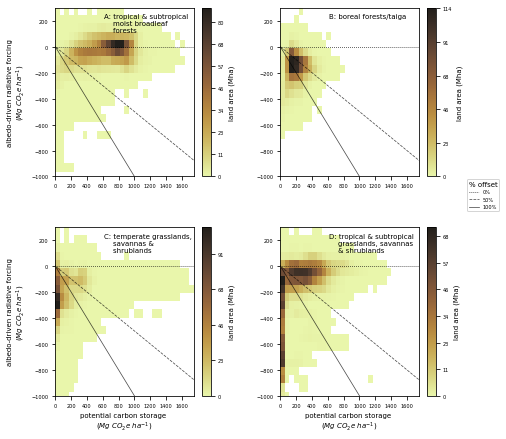

In [30]:
# plot with pct-offset lines
biome_labels = {
                0: 'TrMF',
                5: 'BF',
                7: 'TeS',
                6: 'TrS',
               }
letters = ['A', 'B', 'C', 'D']
max_img_val = np.max([np.max(r[0]) for r in results.values()])
pixel_size_ha = np.abs(np.product(alb.rio.resolution()))/(100**2)
fig = plt.figure(figsize=(7,6.125))
gs = gs = GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
for i, biome_id in enumerate(biome_ids):
    ax_biome = fig.add_subplot(gs[int(i>1), i%2])
    hist2d_biome, xedge_biome, yedge_biome = results[biome_id]
    img = plot_2d_hist_heatmap(i,
                         hist2d_biome,
                         xedge_biome,
                         yedge_biome,
                         ax_labels['emis'],
                         ax_labels['alb'],
                         'offset',
                         pixel_size_ha,
                         ax_biome,
                         hmap_cmap=ptb.cmocean.sequential.Turbid_20.get_mpl_colormap(),
                         lines_cmap = 'gist_heat_r',
                         vmin=0,
                         vmax=None,
                         mask_0=True,
                         linewidth=0.75,
                         linealpha=0.7,
                         low_cmap_frac=0.2,
                         add_cbar=True,
                         add_lgd=(i==3),
                         lgd_bbox_to_anchor=(1.4, 0.9, 0.2, 0.4),
                        )
    if biome_id is None:
        ax_title = 'ALL BIOMES'
    else:
        biome_name = biome_df['BIOME_NAME'][biome_id].lower()
        biome_name = '\n'.join(textwrap.wrap(biome_name,
                                             width=24,
                                             subsequent_indent='    ',
                                            ))
        ax_title = f"{letters[i]}: {biome_name}"
        # add two empty lines to the boreal label, to rectify everything at the top edge of the label
        if re.search('taiga', biome_name):
            ax_title+='\n\n'
    ax_biome.text(620, 110, ax_title, size=7)
    ax_biome.set_ylim(-1000, 300)


# final figure formatting
fig.subplots_adjust(hspace=0.3,
                    wspace=0.3,
                    left=0.1,
                    right=0.89,
                    bottom=0.09,
                    top=0.97,
                   )
fig.savefig('./Figure2_2dhists.pdf',
            dpi=600,
            transparent=False,
            facecolor='white',
           )